# Did you perceive the tinnitus right now? 
## Analysis grouped by country and continent

In [1]:
# add src to path so the noteboook can import utilities.py
import sys
sys.path.append('C:\\Users\\joa24jm\\Documents\\tinnitus-country\\src\\')

In [2]:
# imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from d00_utils import utilities as u
from scipy.stats import ks_2samp, chi2_contingency, f_oneway

In [3]:
# read in intermediate dataframe merged_users
df = pd.read_csv('../../data/02_intermediate/merged_users.csv', index_col = 'Unnamed: 0')

In [4]:
df.shape

(97742, 65)

In [5]:
# replace column names and values for better readability
df.rename(columns = {'question1': 'Tinnitus_right_now'}, inplace = True)
df.Tinnitus_right_now.replace({0.0:'No', 1.0:'Yes'}, inplace = True)

In [6]:
# generate a crosstab and save it as 'ct'
ct = pd.crosstab(df.Continent_Name, df.Tinnitus_right_now)
ct

Tinnitus_right_now,No,Yes
Continent_Name,,
Africa,105,371
Antarctica,2,0
Asia,638,2676
Europe,17462,58748
North America,1816,10505
Oceania,155,1526
South America,241,1180


In [7]:
# stack results and rename for better readability
stacked = ct.stack().reset_index().rename(columns={0:'value'})
stacked.Continent_Name.replace({'North America':'North\nAmerica', 'South America':'South\nAmerica'}, inplace = True)

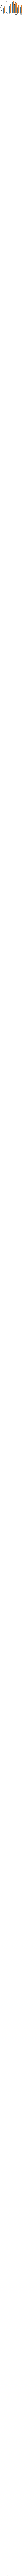

In [8]:
# create plot and add annotations
fig, ax = plt.subplots(1,1)

# remove top and right frame
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

sns.barplot(x= stacked.Continent_Name, y = stacked.value, hue = stacked.Tinnitus_right_now, ax = ax)

# set log scale and labels
ax.set_yscale('log')
ax.set_xlabel('')
ax.set_ylabel('Count')

# show values on bars
u.show_values_on_bars(ax, h_v = 'v', space = 1)


## Plot tinnitus_right_now per country on a horizontal barplot
Define two tresholds for `n_questionnaires > 300` and `n_users > 30`

In [9]:
# get all countries with more than 30 users
u_treshold = 30

s = df.groupby('Country_Name').nunique()['user_id'] > u_treshold
u_countries = s[s].index.tolist()

# from these countries, get all with more than 300 answers
s = df[df.Country_Name.isin(u_countries)].groupby('Country_Name').size() > 300
countries = s[s].index.tolist()

In [16]:
sorted(df.Country_Name.dropna().unique().tolist())

['Albania, Republic of',
 "Algeria, People's Democratic Republic of",
 'American Samoa',
 'Andorra, Principality of',
 'Angola, Republic of',
 'Antarctica (the territory South of 60 deg S)',
 'Antigua and Barbuda',
 'Argentina, Argentine Republic',
 'Australia, Commonwealth of',
 'Austria, Republic of',
 'Belgium, Kingdom of',
 'Bermuda',
 'Bolivia, Republic of',
 'Bosnia and Herzegovina',
 'Brazil, Federative Republic of',
 'Cambodia, Kingdom of',
 'Canada',
 'Cayman Islands',
 'Chile, Republic of',
 "China, People's Republic of",
 'Colombia, Republic of',
 'Costa Rica, Republic of',
 'Croatia, Republic of',
 'Cyprus, Republic of',
 'Czech Republic',
 'Denmark, Kingdom of',
 'Djibouti, Republic of',
 'Dominica, Commonwealth of',
 'Ecuador, Republic of',
 'Egypt, Arab Republic of',
 'Estonia, Republic of',
 'Ethiopia, Federal Democratic Republic of',
 'Fiji, Republic of the Fiji Islands',
 'Finland, Republic of',
 'France, French Republic',
 'Germany, Federal Republic of',
 'Greece, He

In [17]:
df.groupby('Country_Name').nunique()['user_id'].loc['Russian Federation']

16

In [10]:
# generate a sub dataframe with these countries
sub_df = df[df.Country_Name.isin(countries)]

In [11]:
# generate a crosstab and save it as 'ct'
ct = pd.crosstab(sub_df.Country_Name, sub_df.Tinnitus_right_now, normalize = False)

ct

Tinnitus_right_now,No,Yes
Country_Name,,
"Australia, Commonwealth of",95,558
"Austria, Republic of",386,920
"Belgium, Kingdom of",276,688
"Brazil, Federative Republic of",29,305
Canada,322,1989
"France, French Republic",75,378
"Germany, Federal Republic of",10789,40495
"Italy, Italian Republic",53,1147
"Netherlands, Kingdom of the",2388,4833


#### Use X² to determine differences in the occurences

In [12]:
table = np.array(ct)
stat, p, dof, expected = chi2_contingency(table, correction = True)
N = table.sum().sum()
print(f'X²({dof}, N={N}) = {round(stat,2)}, p={round(p,10)}')

X²(14, N=85933) = 2441.44, p=0.0


X² tells us that there are significant differences between those groups. p value is highly significant, perform chi² post-hoc analysis to tell between which groups the significance comes from

In [13]:
from itertools import combinations
from statsmodels.sandbox.stats.multicomp import multipletests

all_combinations = list(combinations(ct.index, 2))
p_vals = []


for comb in all_combinations:
    # subset of contingency table with the pair of countries at hand
    sub_ct = ct.loc[[comb[0], comb[1]], :]
    chi2, p, dof, ex = chi2_contingency(np.array(sub_ct), correction = True)
    p_vals.append(p)

# use corrected pvalues
reject_list, corrected_p_vals = multipletests(p_vals, method='fdr_bh', alpha = 0.05)[:2]

# save result into a dataframe
d = {'corrected p vals':corrected_p_vals, 'reject':reject_list}
res = pd.DataFrame(d, index = all_combinations)
res


,corrected p vals,reject
"(Australia, Commonwealth of, Austria, Republic of)",1.033111e-12,True
"(Australia, Commonwealth of, Belgium, Kingdom of)",1.093903e-10,True
"(Australia, Commonwealth of, Brazil, Federative Republic of)",1.428638e-02,True
"(Australia, Commonwealth of, Canada)",7.517208e-01,False
"(Australia, Commonwealth of, France, French Republic)",4.337215e-01,False
...,...,...
"(Sweden, Kingdom of, United Kingdom of Great Britain & Northern Ireland)",3.372938e-01,False
"(Sweden, Kingdom of, United States of America)",5.351428e-03,True
"(Switzerland, Swiss Confederation, United Kingdom of Great Britain & Northern Ireland)",3.320840e-36,True
"(Switzerland, Swiss Confederation, United States of America)",3.601776e-182,True


In [14]:
# analyse post-hoc chi2 results
res.groupby('reject').count()

,corrected p vals
reject,
False,14
True,91


In [15]:
# Which pairs of countries have similar tinnitus occurences?
res[res.reject == False]

,corrected p vals,reject
"(Australia, Commonwealth of, Canada)",0.751721,False
"(Australia, Commonwealth of, France, French Republic)",0.433722,False
"(Australia, Commonwealth of, Sweden, Kingdom of)",0.176045,False
"(Australia, Commonwealth of, United States of America)",0.236655,False
"(Austria, Republic of, Belgium, Kingdom of)",0.684820,False
"(Brazil, Federative Republic of, Spain, Kingdom of)",0.859232,False
"(Canada, France, French Republic)",0.184467,False
"(Canada, United States of America)",0.175673,False
"(France, French Republic, Sweden, Kingdom of)",0.637732,False
"(France, French Republic, United Kingdom of Great Britain & Northern Ireland)",0.059971,False


In [16]:
# add information about the n_users and the n_questionnaires
# same dataframe with normalized indices
ct2 = pd.crosstab(sub_df.Country_Name, sub_df.Tinnitus_right_now, normalize = 'index')
ct2['n_questionnaires'] = sub_df.groupby('Country_Name').size()
ct2['n_users'] = sub_df.groupby('Country_Name').nunique()['user_id']
ct2

Tinnitus_right_now,No,Yes,n_questionnaires,n_users
Country_Name,,,,
"Australia, Commonwealth of",0.145482,0.854518,666,77
"Austria, Republic of",0.295559,0.704441,1321,68
"Belgium, Kingdom of",0.286307,0.713693,972,44
"Brazil, Federative Republic of",0.086826,0.913174,344,50
Canada,0.139334,0.860666,2341,126
"France, French Republic",0.165563,0.834437,467,72
"Germany, Federal Republic of",0.210378,0.789622,51804,1410
"Italy, Italian Republic",0.044167,0.955833,1220,81
"Netherlands, Kingdom of the",0.330702,0.669298,7268,180


In [17]:
# statistics to report about this subset
ct2.describe()

Tinnitus_right_now,No,Yes,n_questionnaires,n_users
count,15.000000,15.000000,15.000000,15.000000
mean,0.210274,0.789726,5869.933333,210.866667
std,0.122129,0.122129,13058.494343,356.548507
min,0.044167,0.486649,344.000000,38.000000
25%,0.133652,0.709067,591.500000,59.000000
50%,0.181564,0.818436,1220.000000,81.000000
75%,0.290933,0.866348,4426.000000,153.000000
max,0.513351,0.955833,51804.000000,1410.000000


In [18]:
# safe ct2 to .csv excel
# ct2.to_csv('../../results/01_tables/tinnitus_by_country.csv')

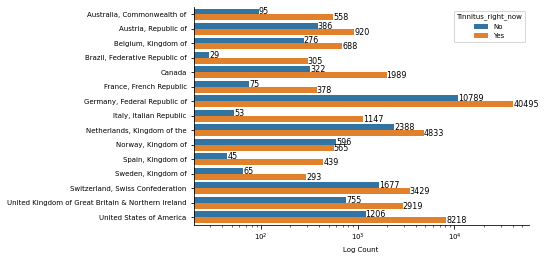

In [19]:
# stack results and rename for better readability
stacked = ct.stack().reset_index().rename(columns={0:'value'})

# decrease font size
matplotlib.rcParams.update({'font.size': 7})

# create plot and add annotations
fig, ax = plt.subplots(1,1)

# remove top and right frame
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

sns.barplot(y= stacked.Country_Name, x = stacked.value, hue = stacked.Tinnitus_right_now, ax = ax,
            orient = 'h')

# set log scale and labels
ax.set_xscale('log')
ax.set_xlabel('Log Count')
ax.set_ylabel('')

# show values on bars
u.show_values_on_bars(ax, h_v = 'h', space = 0.4)

# safe ylabels as reference for normalized bar plot
ylabels = [label.get_text() for label in ax.get_yticklabels()]


In [20]:
ct2.columns

Index(['No', 'Yes', 'n_questionnaires', 'n_users'], dtype='object', name='Tinnitus_right_now')

In [21]:
# stack results and rename for better readability
stacked = ct2[['No', 'Yes']].stack().reset_index().rename(columns={0:'value'})

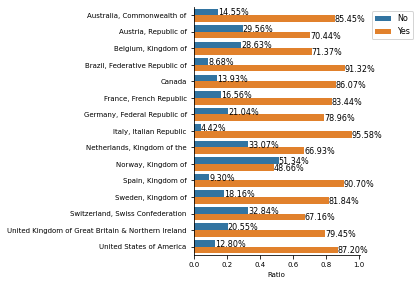

In [38]:
# decrease font size
matplotlib.rcParams.update({'font.size': 7})

# create plot and add annotations
fig, ax = plt.subplots(1,1)

# remove top and right frame
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

sns.barplot(y= stacked.Country_Name, x = stacked.value, hue = stacked.Tinnitus_right_now, ax = ax,
            orient = 'h')

# set log scale and labels
ax.set_xlabel('Ratio')
ax.set_ylabel('')

# ax.legend(bbox_to_anchor=(1.05,1))

# show values on bars
u.show_values_on_bars(ax, h_v = 'h', space = 0.4, normalize = True)

# safe ylabels as reference for normalized bar plot
ylabels = [label.get_text() for label in ax.get_yticklabels()]

# legend outside
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# tight layout for saving the fig
plt.tight_layout()

# save plot as pdf
plt.savefig("C:/Users/joa24jm/Documents/tinnitus-country/results/07_plots/tinnitus-by-country-relative.svg")

## Review 3 JBHI
###  Please discuss the effect of sex differences in the countrie’s user groups for momentary tinnitus occurrence. 

In [42]:
countries = ['DE', 'NL', 'CH', 'GB', 'US']

ser = df[df.country.isin(countries)].groupby(['country', '5', 'Tinnitus_right_now']).size()
pd.DataFrame(ser).to_excel('../../results/01_tables/country_by_sex_by_tinnitus_count.xlsx', index=False)

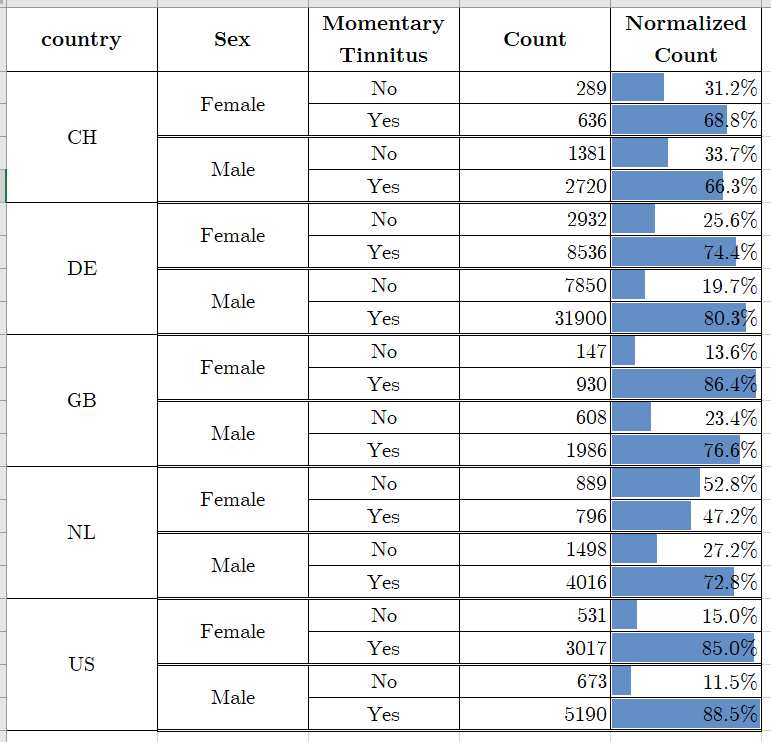